<a href="https://colab.research.google.com/github/abeersethia/CCM_EEG/blob/main/CCM_For_Causality_Between_Generated_EEG_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing and Importing Libraries

In [ ]:
!pip install mne
import numpy as np
import matplotlib.pyplot as plt
from mne import create_info
from mne.io import RawArray
from mne.time_frequency import psd_array_welch
from sklearn.metrics import mean_squared_error
!pip install numpy matplotlib mne scikit-learn

## Generate EEG Data

In [ ]:
from mne import create_info
from mne.io import RawArray
import numpy as np

def generate_eeg_data(n_channels=5, n_samples=1000, sfreq=256):
    # Create random data
    np.random.seed(42)  # For reproducibility
    data = np.random.randn(n_channels, n_samples)

    # Create MNE info structure
    ch_names = [f'EEG {i+1}' for i in range(n_channels)]
    info = create_info(ch_names, sfreq, ch_types='eeg')

    # Create RawArray
    raw = RawArray(data, info)
    return raw


## Delay Embedding Function
A method used to reconstruct the state space of a dynamical system from a time series. It involves creating vectors from the time series data by taking the current value and its previous values, allowing for the analysis of the system's dynamics.

In [ ]:
def delay_embedding(signal, tau, m):
    n = len(signal)
    if n < m + (m - 1) * tau:
        raise ValueError("Signal too short for the specified embedding parameters.")

    tau = int(tau)
    m = int(m)
    return np.array([signal[i:i + m * tau:tau] for i in range(n - m * tau + 1)])


## Convergent Cross Mapping Function
A technique used to assess causal relationships between two time series. It leverages the idea that if one variable influences another, the state of the first variable can help predict the state of the second variable. CCM uses nearest neighbors to find similar states in the embedded space and calculates the correlation between predicted and actual values.

In [ ]:
from sklearn.neighbors import NearestNeighbors

def convergent_cross_mapping(X, Y, tau, m):
    # Delay embedding
    X_embedded = delay_embedding(X, tau, m)
    Y_embedded = delay_embedding(Y, tau, m)

    min_len = min(len(X_embedded), len(Y_embedded))
    X_embedded = X_embedded[:min_len]
    Y_embedded = Y_embedded[:min_len]

    start_index = (m - 1) * tau
    end_index = start_index + min_len
    X_aligned = X[start_index:end_index]
    Y_aligned = Y[start_index:end_index]

    k = m + 1
    k = min(k, min_len)
    if k <= 1:
        return np.nan, np.nan

    # Calculate cross-mapping skill from X to Y
    nn_x = NearestNeighbors(n_neighbors=k).fit(X_embedded)
    distances_y_to_x, indices_y_to_x = nn_x.kneighbors(Y_embedded)

    predicted_Y = np.zeros(min_len)
    for i in range(min_len):
        neighbor_indices = indices_y_to_x[i]
        neighbor_distances = distances_y_to_x[i]
        if np.sum(neighbor_distances) == 0:
            weights = np.ones(k) / k
        else:
            epsilon = 1e-9
            weights = np.exp(-neighbor_distances / (neighbor_distances[0] + epsilon))
            weights /= np.sum(weights)
        predicted_Y[i] = np.average(Y_aligned[neighbor_indices], weights=weights)

    if np.std(predicted_Y) == 0 or np.std(Y_aligned) == 0:
        skill_X_to_Y = np.nan
    else:
        skill_X_to_Y = np.corrcoef(predicted_Y, Y_aligned)[0, 1]

    # Calculate cross-mapping skill from Y to X
    nn_y = NearestNeighbors(n_neighbors=k).fit(Y_embedded)
    distances_x_to_y, indices_x_to_y = nn_y.kneighbors(X_embedded)

    predicted_X = np.zeros(min_len)
    for i in range(min_len):
        neighbor_indices = indices_x_to_y[i]
        neighbor_distances = distances_x_to_y[i]
        if np.sum(neighbor_distances) == 0:
            weights = np.ones(k) / k
        else:
            epsilon = 1e-9
            weights = np.exp(-neighbor_distances / (neighbor_distances[0] + epsilon))
            weights /= np.sum(weights)
        predicted_X[i] = np.average(X_aligned[neighbor_indices], weights=weights)

    if np.std(predicted_X) == 0 or np.std(X_aligned) == 0:
        skill_Y_to_X = np.nan
    else:
        skill_Y_to_X = np.corrcoef(predicted_X, X_aligned)[0, 1]

    return skill_X_to_Y, skill_Y_to_X


## Running the Functions and Plotting the Convergence (Plotting Causality Between EEG Signals) and also plotting the EEG Signals

Creating RawArray with float64 data, n_channels=5, n_times=1000
    Range : 0 ... 999 =      0.000 ...     3.902 secs
Ready.
Running CCM for various library lengths...
Library Length: 13, Skill X->Y: -0.6757, Skill Y->X: -0.5081
Library Length: 63, Skill X->Y: -0.4175, Skill Y->X: -0.5174
Library Length: 113, Skill X->Y: -0.3554, Skill Y->X: -0.5008
Library Length: 163, Skill X->Y: -0.0050, Skill Y->X: -0.2734
Library Length: 213, Skill X->Y: -0.0255, Skill Y->X: -0.2769
Library Length: 263, Skill X->Y: -0.0799, Skill Y->X: -0.2126
Library Length: 313, Skill X->Y: -0.0317, Skill Y->X: -0.1648
Library Length: 363, Skill X->Y: 0.0129, Skill Y->X: -0.1771
Library Length: 413, Skill X->Y: -0.0146, Skill Y->X: -0.1903
Library Length: 463, Skill X->Y: -0.0740, Skill Y->X: -0.1340
Library Length: 513, Skill X->Y: -0.0416, Skill Y->X: -0.0953
Library Length: 563, Skill X->Y: -0.0592, Skill Y->X: -0.0797
Library Length: 613, Skill X->Y: -0.0991, Skill Y->X: -0.0876
Library Length: 663, Skill X-

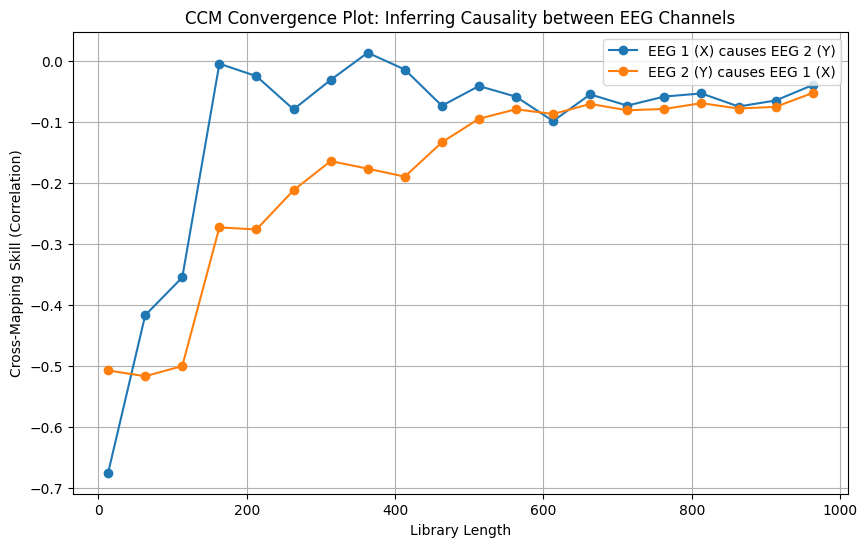

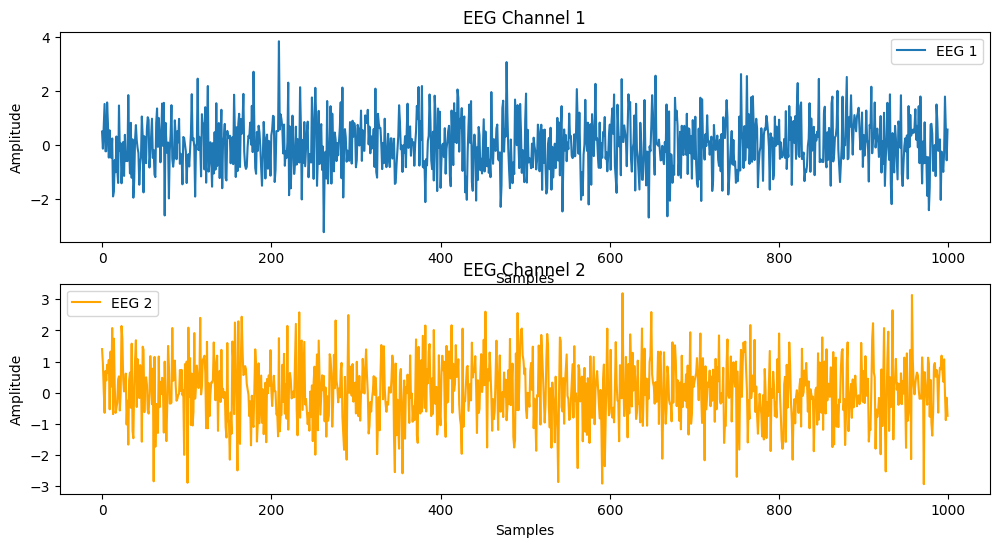

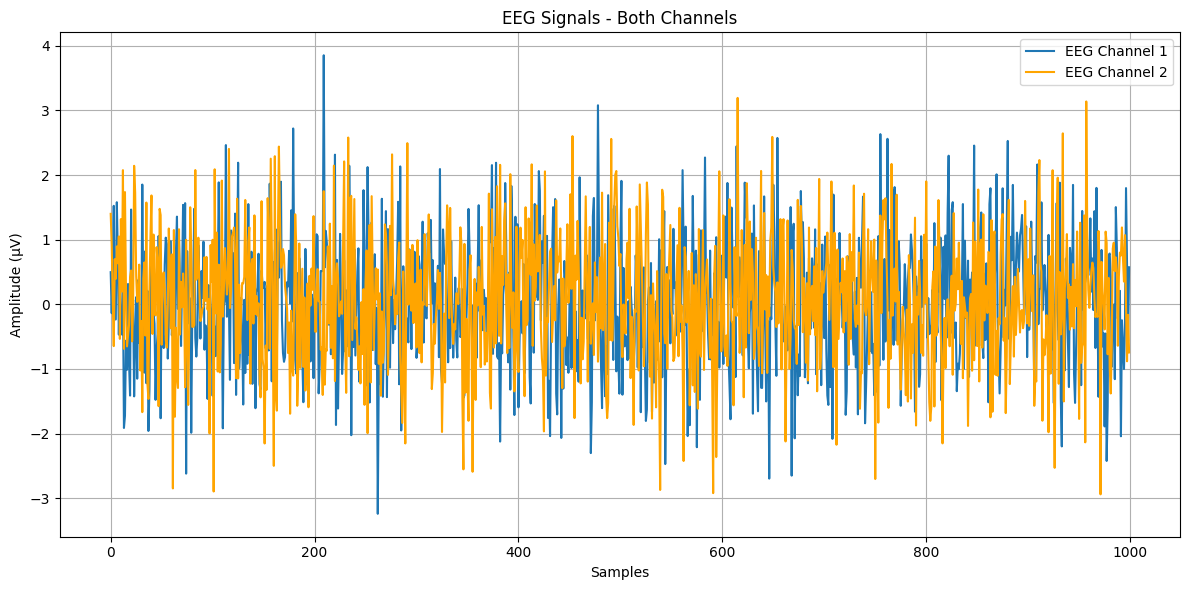

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Generate EEG data
    raw = generate_eeg_data(n_channels=5, n_samples=1000)

    # Select two channels for analysis
    channel_1 = raw.get_data(picks='EEG 1')[0]
    channel_2 = raw.get_data(picks='EEG 2')[0]

    # Parameters for delay embedding
    tau = 1
    m = 3

    # Define a range of library lengths
    library_lengths = np.arange(m * tau + 10, len(channel_1), 50)

    skill_X_to_Y_list = []
    skill_Y_to_X_list = []

    print("Running CCM for various library lengths...")

    for lib_len in library_lengths:
        X_subset = channel_1[:lib_len]
        Y_subset = channel_2[:lib_len]

        skill_X_to_Y, skill_Y_to_X = convergent_cross_mapping(X_subset, Y_subset, tau, m)

        skill_X_to_Y_list.append(skill_X_to_Y)
        skill_Y_to_X_list.append(skill_Y_to_X)

        print(f"Library Length: {lib_len}, Skill X->Y: {skill_X_to_Y:.4f}, Skill Y->X: {skill_Y_to_X:.4f}")

    # Plotting the convergence
    plt.figure(figsize=(10, 6))
    plt.plot(library_lengths, skill_X_to_Y_list, marker='o', linestyle='-', label='EEG 1 (X) causes EEG 2 (Y)')
    plt.plot(library_lengths, skill_Y_to_X_list, marker='o', linestyle='-', label='EEG 2 (Y) causes EEG 1 (X)')
    plt.xlabel('Library Length')
    plt.ylabel('Cross-Mapping Skill (Correlation)')
    plt.title('CCM Convergence Plot: Inferring Causality between EEG Channels')
    plt.legend()
    plt.grid(True)
    plt.show()

    time = np.arange(len(channel_1))
    # Plot EEG signals
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(channel_1, label='EEG 1')
    plt.title('EEG Channel 1')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(channel_2, label='EEG 2', color='orange')
    plt.title('EEG Channel 2')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.figure(figsize=(12, 6))
    plt.plot(time, channel_1, label='EEG Channel 1')
    plt.plot(time, channel_2, label='EEG Channel 2', color='orange')
    plt.title('EEG Signals - Both Channels')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()
